# Comunicados de Política Monetaria
## Parte 1.

En este notebook crearemos un pandas DataFrame con las decisiones de política monetaria de Banxico y haremos un análisis de la información recabada.

In [135]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict, Counter
from unidecode import unidecode
from datetime import datetime
import numpy as np

In [136]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

La información de decisción de política monetaria se encuentra en la siguiente url.

In [137]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

* Entra a `url` y analiza la página.

In [138]:
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


* Como podemos observar, la url objetivo contiene
    * las fechas de decisiones de política monetaria,
    * el resumen de las decisiones de política monetaria y
    * una url que nos dirige a un pdf con el texto completo del Anuncio de Política Monetaria.
    
<h3 style="color:crimson">Ejercicio</h3>

1. Por medio de `requests_html`, extrae los tres puntos antes mencionados y guárdalos dentro de un DataFrame con columnas `"date"`, `"text"` y `"url"`;
2. Con el dataframe seleccionado, filtra todos comunicados anteriores al 15 de febrero de 2008, i.e., queremos todos los comunicados a partir del 15 de Febrero de 2008;
3. Guarda tu DataFrame dentro de un archivo `.pkl` con nombre `comunicados-banxico.pkl`: **hint:** Revisa el uso del método `to_pickle`.

In [139]:
# conexión a la página principal
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [140]:
tbody = r.html.find("tbody", first=True)
tr = tbody.find("tr")

info = []

for tri in tr:
    date_str = tri.find("td[class = 'bmdateview']",first=True).text
    date = datetime.strptime(date_str, "%d/%m/%y")
    
    text = tri.find("td[class = 'bmtextview']",first=True).text
    
    url = tri.find("a",first=True)
    url, *_ = url.absolute_links
    
    record = {
        "date": date,
        "text": text,
        "url": url
    }
    
    info.append(record)


In [141]:
df = pd.DataFrame(info)
df = df.set_index('date') # para hacer index la columna date
df = df.loc[:'2008-02-15'] # filtramos los de después de esta fecha 
df.head()

,text,url
date,,
2020-02-13,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-12-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


In [142]:
df.to_pickle("./comunicados-banxico.pkl")
#hola = pd.read_pickle("./comunicados-banxico.pkl")
#hola

<h3 style="color:crimson">Ejercicio</h3>

Por medio del método `str.extract` para un pandas Series, crea una nueva columna `"category"` que extraiga del texto si la tasa se 
1. `"mantiene"`
2. `"incrementa"`
3. `"disminuye"`

In [143]:
sr = df['text']

category = sr.str.extract(pat = '(mantiene|incrementa|disminuye)') 

df = df.assign(category=category)
df.head(10)

,text,url,category
date,,,
2020-02-13,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-12-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2019-03-28,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2019-02-07,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene


<h3 style="color:crimson">Ejercicio</h3>

Cuenta las veces en las que la tasa se mantuvo, se incrementó o se disminuyó.

In [144]:
category_count = df['category']
pd.Series(category_count).value_counts()


mantiene      72
incrementa    18
disminuye     16
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Reproduce la siguiente figura sobre los comunicados de prensa de Banxico:
1. La gráfica de la izquierda representa una serie de tiempo sobre los comunicados de banxico. Si `y=1`, la tasa de referencia se incrementó; si `y=0`, la tasa se mantuvo; finalmente, si `y=-1`, la tasa disminuyó.
2. La gráfica de la derecha es una gráfica de barras del ejercicio anterior

In [145]:
def label_category(row):
   if row['category'] == 'mantiene' :
      return 0
   if row['category'] == 'incrementa' :
      return 1
   if row['category'] == 'disminuye' :
      return -1 
    
    
df['category_label']=df.apply(lambda row: label_category(row), axis=1)#.plot.scatter(x=index,y=label_category,marker='+')


#df.plot.scatter(x=df['date'],y=df['category_label'],marker='+')



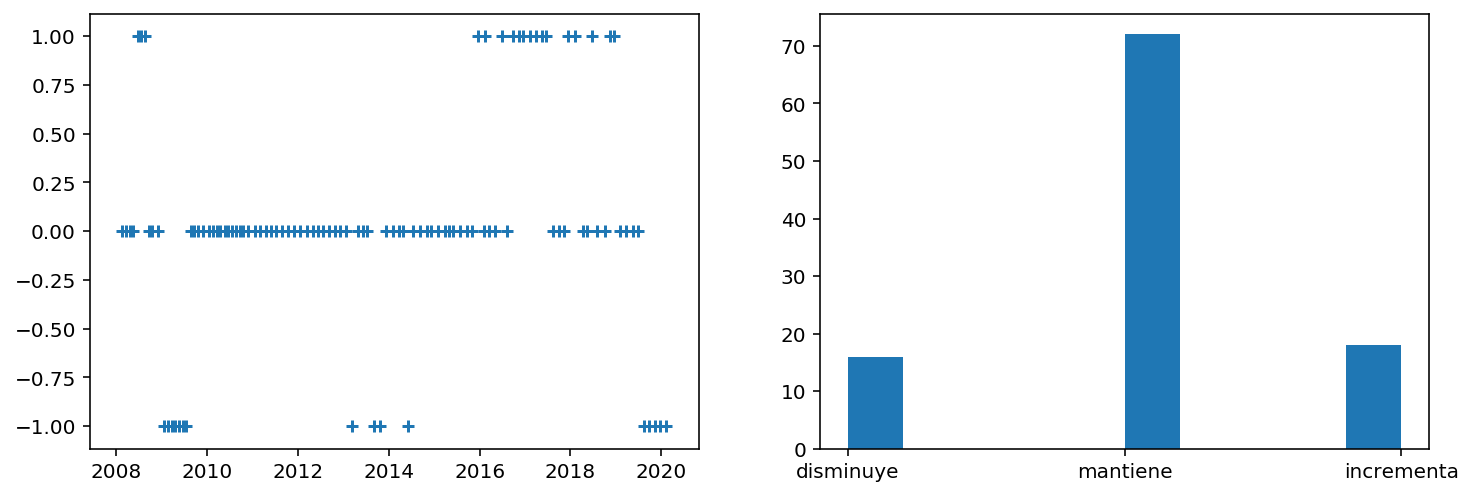

In [146]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(x=df.index, y=df['category_label'], marker='+')
ax2.hist(x=df['category'])
plt.show()

<h3 style="color:crimson">Ejercicio</h3>

Agrupa por año y cuenta el número de comunicados en un año para cada categoría.

In [147]:
grouped = (df.groupby([df.index.strftime('%Y'),'category'])['category']
    .count())
    
grouped.head()


      category  
2008  incrementa     3
      mantiene       7
2009  disminuye      7
      mantiene       4
2010  mantiene      11
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Con el resultado anterior, replica la siguiente gráfica

In [148]:
mantiene = pd.DataFrame(grouped.xs('mantiene', level=1)).rename(columns={"category": "mantiene"})
disminuye = pd.DataFrame(grouped.xs('disminuye', level=1)).rename(columns={"category": "disminuye"})
incrementa = pd.DataFrame(grouped.xs('incrementa', level=1)).rename(columns={"category": "incrementa"})


grouped_new = mantiene.join(disminuye).join(incrementa).fillna(0)
grouped_new.head()

,mantiene,disminuye,incrementa
2008,7,0.0,3.0
2009,4,7.0,0.0
2010,11,0.0,0.0
2011,8,0.0,0.0
2012,8,0.0,0.0


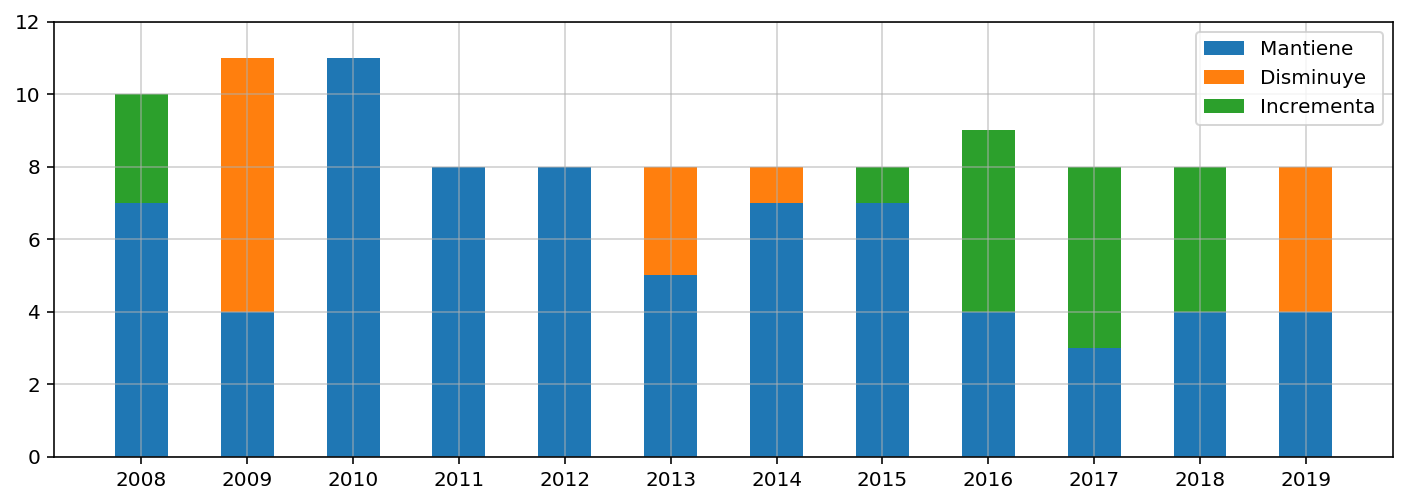

In [149]:

N = len(grouped_new)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, grouped_new['mantiene'], width)
p2 = plt.bar(ind, grouped_new['disminuye'], width,
             bottom=grouped_new['mantiene'])
p3 = plt.bar(ind, grouped_new['incrementa'], width,
             bottom=grouped_new['mantiene'])

#plt.ylabel('')
#plt.title('')

plt.xticks(ind, grouped_new.index)
plt.yticks(np.arange(0, 13, 2))
plt.legend((p1[0], p2[0], p3[0]), ('Mantiene', 'Disminuye', 'Incrementa'))
plt.grid(alpha=0.6)

plt.show()

# Banxico Parte 2

* Ocupando únicamente pandas, numpy; matplotlib; seaborn,
con la info obtenida en la parte 1 (pandas DataFrame) modelar con Naivee Bayes, 
si un documento dado pertenece a la clase 'mantiene', 'incrementa', 'disminuye'. Para esto, descargar los PDFs

## Pasos

1. Descargar PDFs
2. Limpiar los datos
3. Eliminar de todos los archivos las palabras que contengan 'mantiene', 'incrementa', 'disminuye'
4. Parte los documentos entre un set de entrenamiento (0.8) y uno de prueba (0.2)
5. Entrena el modelo con los documentos de entrenamiento y valida el resultado con una matriz de confusión 
   usando la base de prueba



In [248]:
import requests
import os 
from collections import defaultdict
import PyPDF2
from sklearn.model_selection import train_test_split
import re
import pickle
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk import corpus
from collections import defaultdict
from tqdm.notebook import tqdm


In [177]:
# descarga papers 
for i in range(len(df)):
    url = df['url'][i]
    r = requests.get(url)
    
    paper = r.content

    # recomendable primero crear una carpeta si no existe donde guardaré mis pdfs
    if not os.path.exists("descargas_pdfs"):  
        os.mkdir("descargas_pdfs")
    
    full_path = os.path.join("descargas_pdfs", f"paper{i}.pdf")
    
    # escribe cada pdf en mi carpeta
    with open(full_path,"wb") as f: # wb write binary
        f.write(paper)
    

In [230]:
# lee papers y los guarda en un diccionario con disminuye, mantiene e incrementa como llaves

d = defaultdict(list)

for i in range(len(df)):
    
    full_path = os.path.join("descargas_pdfs", f"paper{i}.pdf")
    
    pdf_file = open(full_path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = Counter(range(number_of_pages))

    text_paper_i = ''
    for j in c:
       page = read_pdf.getPage(j)
       page_content = page.extractText()
       text_paper_i = text_paper_i + page_content # leemos el pdf completo y lo guardamos en text_paper_i
            
    d[df['category'][i]].append(text_paper_i)
      

In [239]:
k1, k2, k3 = 'mantiene', 'incrementa', 'disminuye'

In [ ]:
def limpia_dialogo(texto):
    limpio = texto.lower()
    limpio = re.sub("[^\w ]", "", limpio) # quitamos todo lo que no sea alfanumerico o espacio 
    return limpio

In [238]:
D1 = [limpia_dialogo(doc) for doc in d[k1]]
D2 = [limpia_dialogo(doc) for doc in d[k2]]
D3 = [limpia_dialogo(doc) for doc in d[k3]]

# quiero partir mis datos en un train group y un test group de datos

D1, D1_test = train_test_split(D1,test_size = 0.2)
D2, D2_test = train_test_split(D2,test_size = 0.2)
D3, D3_test = train_test_split(D3,test_size = 0.2)

In [242]:

N1 = len(D1)
N2 = len(D2)
N3 = len(D3)
N = N1 + N2 + N3
N

83

In [341]:
# quitamos las palabras que no nos interesan 
stopwords = corpus.stopwords.words("spanish")
aditional_stopwords = ['mantener','disminuir','incrementar', 'mantengan','disminuyan','incrementen','además','general','vez']
stopwords = stopwords + aditional_stopwords
len(stopwords)


313

In [342]:
V1 = [palabra for dialogo in D1 for palabra in dialogo.split() if palabra not in stopwords]
V2 = [palabra for dialogo in D2 for palabra in dialogo.split() if palabra not in stopwords]
V3 = [palabra for dialogo in D3 for palabra in dialogo.split() if palabra not in stopwords]


In [343]:
V1_c = pd.Series(V1, name='k1').value_counts()
V2_c = pd.Series(V2, name = 'k2').value_counts()
V3_c = pd.Series(V3, name = 'k3').value_counts()


In [344]:
V = set(V1) | set(V2) | set(V3)
vocab = pd.DataFrame(index=V)
vocab.shape

(3209, 0)

In [345]:
# likelihood
L = (vocab.join(V1_c, how = "left")
    .join(V2_c, how = "left")
    .join(V3_c, how = "left"))

#L.to_csv('out.csv')

In [346]:
# likelihood

L = L.fillna(0) + 1 #numerador 
L = L / L.sum(axis=0) # L.sum(axis=0)  suma el total por clase 

L.sort_values("k1",ascending = False)
L.sample(10)


,k1,k2,k3
tomando,0.000601,0.001588,0.000783
alcista,0.000127,0.000238,0.000224
mantenido,0.001297,0.000874,0.001678
subieron,0.000095,0.000159,0.000112
benigno,0.000063,0.000079,0.000112
agraven,0.000063,0.000079,0.000112
atenuaría,0.000032,0.000159,0.000112
acuerdos,0.000158,0.000079,0.000112
afecta,0.000095,0.000079,0.000224
sufra,0.000063,0.000079,0.000112


In [368]:
log_L = np.log(L)

log_prior_k1 = np.log(N1/N)
log_prior_k2 = np.log(N2/N)
log_prior_k3 = np.log(N3/N)

log_priors = np.array([log_prior_k1,log_prior_k2,log_prior_k3])


# Probando el modelo

In [348]:
len(D1_test)
d_test = D1_test[0]
f = set([palabra for palabra in d_test.split() if palabra in V])

In [349]:
res = log_L.loc[f].sum(axis=0) + log_priors
res

k1   -3679.131708
k2   -3651.017602
k3   -3777.030340
dtype: float64

In [350]:
res.idxmax()# k2 

'k2'

In [351]:
D_test = D1_test + D2_test + D3_test
print(len(D_test))
y_test = ["k1"]*len(D1_test) + ["k2"]*len(D2_test) + ["k3"]*len(D3_test)

23


In [352]:
yhat_test = [] 
for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    yhat_test.append(res.idxmax())

print(y_test)
print(yhat_test)    

['k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k2', 'k3', 'k3', 'k3', 'k3']
['k2', 'k3', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k3', 'k3', 'k3', 'k3']


In [353]:
from  sklearn.metrics import confusion_matrix
confusion_matrix(y_test,yhat_test)

array([[12,  2,  1],
       [ 1,  3,  0],
       [ 0,  0,  4]])

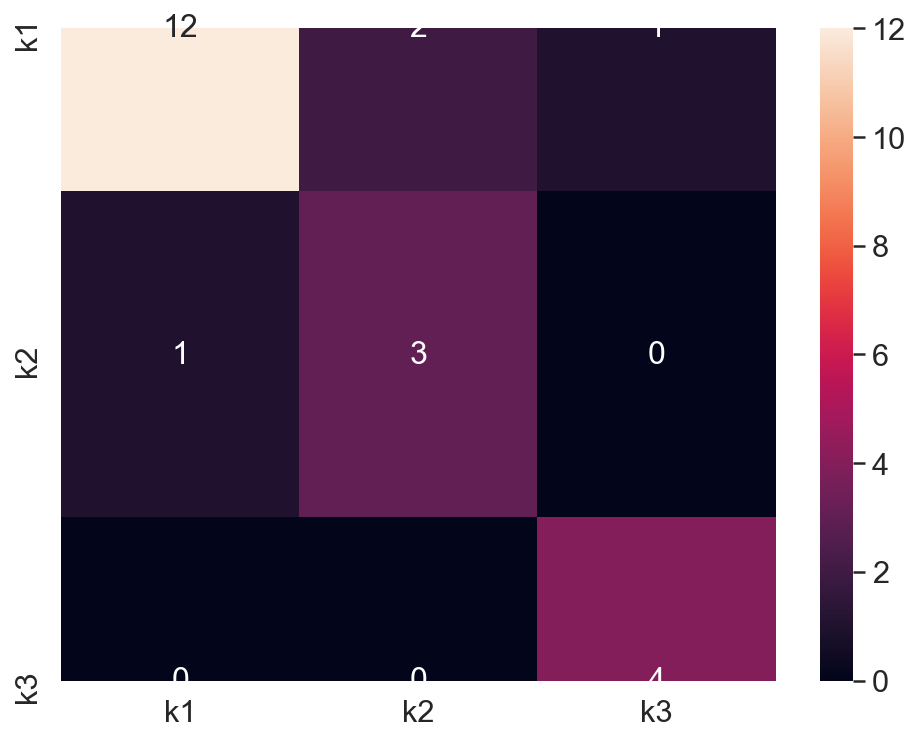

In [354]:
import seaborn as sn
array = confusion_matrix(y_test,yhat_test)
df_cm = pd.DataFrame(array, index = ['k1','k2','k3'],
                  columns = ['k1','k2','k3'])
plt.figure(figsize = (8,6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
